In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema, NanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
import hist
import coffea.nanoevents.methods.vector as vector
import matplotlib.pyplot as plt
import warnings
import hist.dask as dhist
import dask
import pickle
import os

/tmp/ipykernel_929178/1893946785.py:7: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [3]:
path = '/cms/cephfs/data/store/user/cmoore24/samples/qcd/470to600/'
files = os.listdir(path)

In [4]:
events = NanoEventsFactory.from_root(
    {f'{path}{files[2]}':"/Events"},
    delayed=True,
    schemaclass=PFNanoAODSchema,
    metadata={'dataset':'qcd'}
).events()

In [5]:
fields = {}
for i in events.fields:
    fields[i] = events[i].fields
    for j in events[i].fields:
        try:
            fields[f'{i}_{j}'] = events[i][j].fields
        except:
            continue

In [6]:
mask = []
for i in list(fields.keys()):
    if 'charge' in i:
        mask.append(i)
    else:
        continue

In [7]:
mask

['Electron_charge',
 'LowPtElectron_charge',
 'Flag_chargedHadronTrackResolutionFilter',
 'boostedTau_chargedIso',
 'boostedTau_charge',
 'Tau_chargedIso',
 'Tau_charge',
 'Photon_charge',
 'SV_charge',
 'Muon_charge',
 'IsoTrack_charge',
 'TrigObj_l1charge',
 'PFCands_charge',
 'GenVisTau_charge']

In [8]:
hgg = ak.from_parquet('/project01/ndcms/cmoore24/skims/lund_output/hgg.parquet')
qcd = ak.from_parquet('/project01/ndcms/cmoore24/skims/lund_output/q476.parquet')

In [9]:
def selection(sample):
    selection = (
        (sample.goodjets.nmuons == 0)
        & (sample.goodjets.nelectrons == 0)
        & (sample.goodjets.ntaus == 0)
        & (sample.goodjets.btag_count == 0)
    )
    sample = sample[ak.flatten(selection)]
    return sample

In [10]:
len(hgg), len(qcd)

(57426, 4312705)

In [11]:
hgg = selection(hgg)

In [12]:
qcd = selection(qcd)

In [13]:
len(hgg), len(qcd)

(42909, 3140770)

In [14]:
hgg_lund = ak.flatten(hgg.goodjets.lund_decluster)

In [15]:
qcd_lund = ak.flatten(qcd.goodjets.lund_decluster)

In [16]:
x = ak.flatten(hgg_lund.Delta)

In [17]:
y = ak.flatten(hgg_lund.kt)

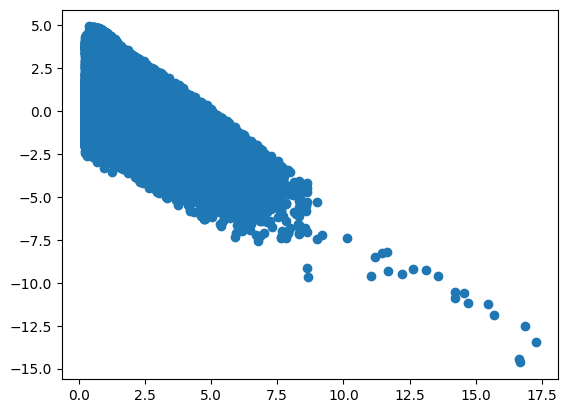

In [18]:
plt.scatter(np.log(1/x),np.log(y))
plt.show()

In [19]:
mask = (x > 0) & (y > 0)
log_delta = np.log((1/x[mask]).to_numpy())
log_kt = np.log(y[mask].to_numpy())

# Define the number of bins for the histogram
num_bins = 100  # Adjust this as needed for resolution

# Compute the 2D histogram for density
density, xedges, yedges = np.histogram2d(log_delta, log_kt, bins=num_bins, density=True)
N_jets = len(log_delta)
#density /= N_jets

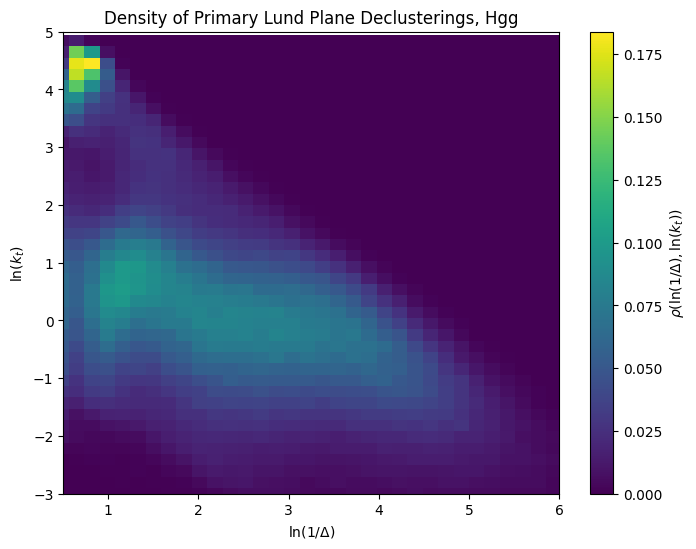

In [20]:
plt.figure(figsize=(8, 6))
plt.imshow(density.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap="viridis")
plt.colorbar(label=r"$\rho(\ln(1/\Delta), \ln(k_t))$")
plt.xlabel(r"$\ln(1/\Delta)$")
plt.ylabel(r"$\ln(k_t)$")
plt.xlim(0.5,6)
plt.ylim(-3, 5)
plt.title("Density of Primary Lund Plane Declusterings, Hgg")
plt.show()

In [21]:
x = ak.flatten(qcd_lund.Delta)

In [22]:
y = ak.flatten(qcd_lund.kt)

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: divide by zero encountered in log
  return impl(*broadcasted_args, **(kwargs or {}))


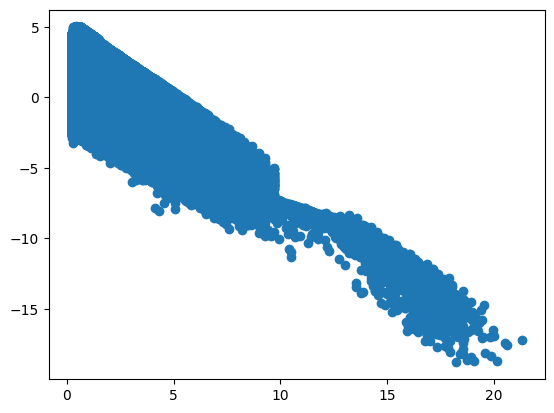

In [23]:
plt.scatter(np.log(1/x),np.log(y))
plt.show()

In [24]:
mask = (x > 0) & (y > 0)
log_delta = np.log((1/x[mask]).to_numpy())
log_kt = np.log(y[mask].to_numpy())

# Define the number of bins for the histogram
num_bins = 100  # Adjust this as needed for resolution

# Compute the 2D histogram for density
density, xedges, yedges = np.histogram2d(log_delta, log_kt, bins=num_bins, density=True)
N_jets = len(log_delta)
#density /= N_jets

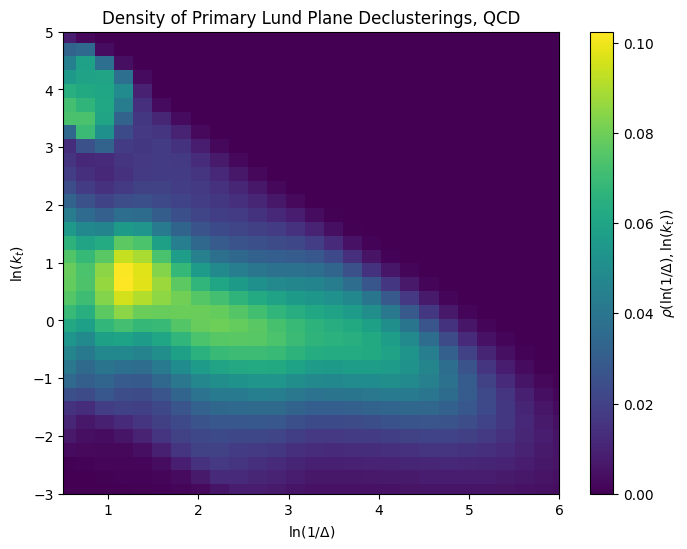

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(density.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap="viridis")
plt.colorbar(label=r"$\rho(\ln(1/\Delta), \ln(k_t))$")
plt.xlabel(r"$\ln(1/\Delta)$")
plt.ylabel(r"$\ln(k_t)$")
plt.xlim(0.5,6)
plt.ylim(-3, 5)
plt.title("Density of Primary Lund Plane Declusterings, QCD")
plt.show()

In [29]:
a = events.FatJet.constituents.pf.fields

In [28]:
events.FatJet.particleNet_mass.compute()

<Array [[-1e+03, -1e+03], ..., [-1e+03, ...]] type='89000 * var * float32[p...'>